### Load Bi-Encoder: Unsupervised SimCSE & Evaluate

In [1]:
import torch
from transformers import AutoTokenizer, AutoModel

import numpy as np
from scipy import spatial, stats

In [2]:
# Device: GPU
device=torch.device("cuda:0")

# Checkpoint: Unsupervised SimCSE
tokenizer_bi=AutoTokenizer.from_pretrained("princeton-nlp/unsup-simcse-roberta-base")
bi_enc=AutoModel.from_pretrained("princeton-nlp/unsup-simcse-roberta-base").to(device)
bi_enc.eval()
print("Loaded!")

Loaded!


In [3]:
# STS Benchmark Test Set
with open("../dataset/stsbenchmark/sts-test.csv", "r") as f:
    data=f.read().split("\n")
    data.remove("")
    f.close()
    
preds=[]
labels=[]
for _data in data:
    label, sent0, sent1=_data.split("\t")[4:7]
    labels.append(float(label))
    
    # Encode Sentence
    enc0=tokenizer_bi.encode(sent0)
    enc1=tokenizer_bi.encode(sent1)
    
    # Forward
    cls0=bi_enc(torch.tensor([enc0]).to(device)).last_hidden_state[:,0,:]
    cls1=bi_enc(torch.tensor([enc1]).to(device)).last_hidden_state[:,0,:]
    
    pred=1-spatial.distance.cosine(np.array(cls0.detach().cpu()), np.array(cls1.detach().cpu()))
    preds.append(pred)

In [4]:
np.corrcoef(preds, labels)

array([[1.        , 0.81180198],
       [0.81180198, 1.        ]])

In [5]:
stats.spearmanr(preds, labels)

SpearmanrResult(correlation=0.8009763763165447, pvalue=4.38233081262766e-309)

### Create Pseudo-Labels using Bi-Encoder

In [1]:
import torch
from transformers import AutoTokenizer, AutoModel

import pandas as pd
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt

from random import sample

In [2]:
# Device: GPU
device=torch.device("cuda:0")

# Checkpoint: Unsupervised SimCSE
tokenizer_bi=AutoTokenizer.from_pretrained("princeton-nlp/unsup-simcse-roberta-base")
bi_enc=AutoModel.from_pretrained("princeton-nlp/unsup-simcse-roberta-base").to(device)
bi_enc.eval()
print("Loaded!")

Loaded!


### How to Make Sentence Pairs:
### a. Same Pairs in STS-B Train Set (NOT Use Labels)

In [3]:
def pseudo_label(dataset_path, tokenizer, model):
    """
    Same Pairs in STS-B Train Set
    """
    # Read Dataset
    sents0=[]
    sents1=[]
    if "stsbenchmark" in dataset_path:
        data=open(dataset_path).read().split("\n")
        data.remove("")
        
        # Parse Dataset
        for _data in data:
            sent0, sent1=_data.split("\t")[5:7]
            
            sents0.append(sent0)
            sents1.append(sent1)
            
    # Make DataFrame
    df=pd.DataFrame({
        "sent0": sents0,
        "sent1": sents1,
    })
    
    # Pseudo-Labeling
    pseudo_labels=[]
    for idx in df.index:
        row=df.loc[idx]
        
        # Encode Sentence
        enc0=tokenizer.encode(row["sent0"])
        enc1=tokenizer.encode(row["sent1"])
        
        # Forward
        cls0=model(torch.tensor([enc0]).to(model.device)).last_hidden_state[:,0,:]
        cls1=model(torch.tensor([enc1]).to(model.device)).last_hidden_state[:,0,:]
        
        pred=1-spatial.distance.cosine(np.array(cls0.detach().cpu()), np.array(cls1.detach().cpu()))
        pseudo_labels.append(pred)
        
    # Append Pseudo-Label Column
    df["pseudo_label"]=pseudo_labels
    
    return df

In [4]:
df=pseudo_label(
    dataset_path="../dataset/stsbenchmark/sts-train.csv",
    tokenizer=tokenizer_bi,
    model=bi_enc
)
df.head(5)

,sent0,sent1,pseudo_label
0,A plane is taking off.,An air plane is taking off.,0.982021
1,A man is playing a large flute.,A man is playing a flute.,0.969140
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,0.920545
3,Three men are playing chess.,Two men are playing chess.,0.891384
4,A man is playing the cello.,A man seated is playing the cello.,0.910757


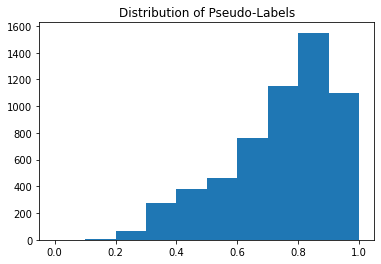

In [5]:
plt.hist(df["pseudo_label"], bins=10, range=(0,1))
plt.title("Distribution of Pseudo-Labels")
plt.show()

In [6]:
# Save Dataset
df.to_csv("../dataset/bi2cross-sts-train.csv", index=False)

### b. Random Pairs

In [7]:
def pseudo_label(dataset_path, tokenizer, model):
    """
    Random Pairs
    """
    # Read All Sentences from Dataset
    sents=[]
    if "stsbenchmark" in dataset_path:
        data=open(dataset_path).read().split("\n")
        data.remove("")
        
        for _data in data:
            sents.extend(_data.split("\t")[5:7])
            
    # Random Pairing
    sents0=[]
    sents1=[]
    while len(sents)>0:
        sent0, sent1=sample(sents, 2)
        
        sents0.append(sent0)
        sents1.append(sent1)
        
        sents.remove(sent0)
        sents.remove(sent1)
        
    # Pseudo-Labeling
    pseudo_labels=[]
    for sent0, sent1 in zip(sents0, sents1):
        # Encode Sentence
        enc0=tokenizer.encode(sent0)
        enc1=tokenizer.encode(sent1)
        
        # Forward
        cls0=model(torch.tensor([enc0]).to(model.device)).last_hidden_state[:,0,:]
        cls1=model(torch.tensor([enc1]).to(model.device)).last_hidden_state[:,0,:]
        
        pred=1-spatial.distance.cosine(np.array(cls0.detach().cpu()), np.array(cls1.detach().cpu()))
        pseudo_labels.append(pred)
        
    # Make DataFrame
    df=pd.DataFrame({
        "sent0": sents0,
        "sent1": sents1,
        "pseudo_label": pseudo_labels
    })
    
    return df

In [8]:
df=pseudo_label(
    dataset_path="../dataset/stsbenchmark/sts-train.csv",
    tokenizer=tokenizer_bi,
    model=bi_enc
)
df.head(5)

,sent0,sent1,pseudo_label
0,Malaysia to extradite Iranian for attack on Is...,A little bird floating in the water.,0.287990
1,School bomb attack kills two in southern Thailand,A small child in a pink dress sits on a table.,0.263205
2,Garner said the self-proclaimed mayor of Baghd...,A woman is playing a flute.,0.271988
3,Syria launches ground assault in Aleppo,"Since early May, the city has received 1,400 r...",0.270703
4,A man is slicing a potato.,Former CIA officer sentenced to 30 months in p...,0.262453


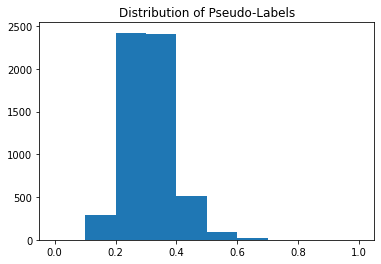

In [9]:
plt.hist(df["pseudo_label"], bins=10, range=(0,1))
plt.title("Distribution of Pseudo-Labels")
plt.show()

In [10]:
# Save Dataset
df.to_csv("../dataset/bi2cross-random-train.csv", index=False)

### Train Cross-Encoder with Pseudo-Labels & Evaluate

In [1]:
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.cuda.amp as amp
from torch.utils.tensorboard import SummaryWriter

from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup

import numpy as np
from scipy import spatial, stats

In [2]:
# Device: GPU
device=torch.device("cuda:0")

# Hyperparams
max_sent_len=256
batch_size=16
accum_steps=1
lr=5e-5
epochs=5

In [3]:
class PseudoLabelDataset(Dataset):
    def __init__(self, path, tokenizer):
        self.data=[]
        self.label=[]
        
        # Read Dataset
        df=pd.read_csv(path)
        
        for idx in df.index:
            row=df.loc[idx]
            
            # Encode Sentence
            enc0=tokenizer.encode(row["sent0"], truncation=True, max_length=max_sent_len)
            enc1=tokenizer.encode(row["sent1"], truncation=True, max_length=max_sent_len)
            
            # Append Data
            self.data.append(enc0[:-1]+[tokenizer.sep_token_id]+enc1[1:])
            self.label.append(float(row["pseudo_label"]))
            
        print(len(self.data), "data")
            
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    
    def __len__(self):
        return len(self.data)

In [4]:
def get_collate_fn(tokenizer):
    def collate_fn(batch):
        max_seq_len=0
        for data, _ in batch:
            if len(data)>max_seq_len: max_seq_len=len(data)

        batch_data=[]
        batch_label=[]
        for data, label in batch:
            data.extend([tokenizer.pad_token_id]*(max_seq_len-len(data)))
            batch_data.append(data)

            batch_label.append(label)

        return torch.tensor(batch_data), torch.tensor(batch_label)
    
    return collate_fn

In [5]:
class CrossEncoder(nn.Module):
    def __init__(self, pretrained):
        super().__init__()
        
        # Pre-Trained LM
        self.pretrained=pretrained
        # Pooling Layer: MLP
        self.pooler=nn.Linear(pretrained.config.hidden_size, 1)
        
    def forward(self, x):
        x=self.pretrained(x)
        cls=x.last_hidden_state[:,0,:]
        return self.pooler(cls)

In [6]:
def train_cross_encoder_with_pseudo_labels(pseudo_label_path, loss_func):
    """
    Bi-Encoder -> Cross-Encoder Distillation
    """
    # Pre-Trained Tokenizer
    tokenizer=AutoTokenizer.from_pretrained("roberta-base")
    # Pseudo-Labeled Dataset
    dataset_train=PseudoLabelDataset(path=pseudo_label_path, tokenizer=tokenizer)
    dataloader_train=DataLoader(
        dataset_train,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=get_collate_fn(tokenizer=tokenizer)
    )
    
    # Pre-Trained LM
    pretrained=AutoModel.from_pretrained("roberta-base").to(device)
    # Model: Cross-Encoder
    model=CrossEncoder(pretrained=pretrained).to(device)
    model.train()
    
    # Loss: MSE
    if loss_func=="MSE":
        train_loss=nn.MSELoss()
    # Loss: BCE
    elif loss_func=="BCE":
        train_loss=nn.BCEWithLogitsLoss()
        
    # Optimizer, Scheduler
    optimizer=AdamW(model.parameters(), lr=lr)
    scheduler=get_linear_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=int(0.05*epochs*len(dataset_train)/(accum_steps*batch_size)),
        num_training_steps=int(epochs*len(dataset_train)/(accum_steps*batch_size))
    )

    # Mixed Precision: GradScaler
    scaler=amp.GradScaler()

    # Tensorboard
    writer=SummaryWriter()

    step_global=0
    for epoch in range(epochs):
        _loss=0
        optimizer.zero_grad()

        for step, (data, label) in enumerate(dataloader_train):
            # Load Data, Label
            data=data.to(device)
            label=label.to(device)

            # Forward
            with amp.autocast():
                pred=model(data)
                loss=train_loss(pred, label.unsqueeze(-1))/accum_steps
            # Backward
            scaler.scale(loss).backward()
            _loss+=loss.item()

            # Step
            if (step+1)%accum_steps==0:
                step_global+=1

                # Tensorboard
                writer.add_scalar(
                    f'loss_train/Cross-Encoder-Distilled_batch{int(accum_steps*batch_size)}_lr{lr}_epochs{epochs}',
                    _loss,
                    step_global
                )
                _loss=0

                # Optimizer, Scheduler
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()
                optimizer.zero_grad()

        # Save Model
        model.to(torch.device("cpu"))
        torch.save(
            model,
            f'../model/Cross-Encoder-Distilled_batch{int(accum_steps*batch_size)}_lr{lr}_epoch{epoch+1}of{epochs}'
        )
        model.to(device)

In [7]:
def evaluate_distilled_cross_encoder(model_path):
    # Pre-Trained Tokenizer
    tokenizer=AutoTokenizer.from_pretrained("roberta-base")
    # Load Trained Model: Cross-Encoder
    model=torch.load(model_path).to(device)
    model.eval()
    
    # STS Benchmark Test Set
    with open("../dataset/stsbenchmark/sts-test.csv", "r") as f:
        stsb_test=f.read()
        f.close()

    preds=[]
    labels=[]
    for data in stsb_test.split("\n")[:-1]:
        label, sent0, sent1=data.split("\t")[4:7]
        labels.append(float(label))

        # Encode Sentence
        enc0=tokenizer.encode(sent0)
        enc1=tokenizer.encode(sent1)

        # Forward
        input_=torch.tensor([enc0[:-1]+[tokenizer.sep_token_id]+enc1[1:]])
        pred=model(input_.to(device))

        preds.append(pred[0].item())
        
    print(np.corrcoef(preds, labels))
    print(stats.spearmanr(preds, labels))

In [8]:
# Case a. Same Pairs in STS-B Train Set
train_cross_encoder_with_pseudo_labels(pseudo_label_path="../dataset/bi2cross-sts-train.csv", loss_func="BCE")

# Case b. Random Pairs
# train_cross_encoder_with_pseudo_labels(pseudo_label_path="../dataset/bi2cross-random-train.csv", loss_func="BCE")

5749 data


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warn

In [13]:
# Evaluate
evaluate_distilled_cross_encoder(model_path="../model/Cross-Encoder-Distilled_batch16_lr5e-05_epoch4of5")

[[1.         0.81972359]
 [0.81972359 1.        ]]
SpearmanrResult(correlation=0.8225849566372455, pvalue=0.0)
